<a href="https://colab.research.google.com/github/WilliamShengYangHuang/RC18_Machine_Learning/blob/main/variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Autoencoders (VAEs)
======

The VAE implemented here uses the setup found in most VAE papers: a multivariate Normal distribution for the conditional distribution of the latent vectors given and input image ($q_{\phi}(z | x_i)$ in the slides) and a multivariate Bernoulli distribution for the conditional distribution of images given the latent vector ($p_{\theta}(x | z)$ in the slides). Using a Bernoulli distribution, the reconstruction loss (negative log likelihood of a data point in the output distribution) reduces to the pixel-wise binary cross-entropy. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf), Appendix C.1 for details.

In [157]:
import sys
from os.path import exists
from packaging import tags


%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F


Parameter Settings
-------------------


In [158]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 8 #@param{type:'slider', min:1, max:10, step:1}
num_epochs = 250 #@param{type:'slider', min:1, max:1000, step:1}
batch_size = 8 #@param{type:'slider', min:1, max:128, step:1}
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True #@param{type:'boolean'}

# # 10-d latent space, for comparison with non-variational auto-encoder
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [159]:
# @title
"""
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
"""

"\nimport torchvision.transforms as transforms\nfrom torch.utils.data import DataLoader\nfrom torchvision.datasets import MNIST\n\nimg_transform = transforms.Compose([\n    transforms.ToTensor()\n])\n\ntrain_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)\ntrain_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\n\ntest_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)\ntest_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)\n"

## Own Data

In [160]:
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from torchvision.transforms import ToTensor

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('L')  # convert image to grayscale
        if self.transform:
            image = self.transform(image)
        return image


In [161]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [162]:
dir = '/content/drive/My Drive/phd_thesis_data/deep_city/pix2pix/raw/Ebird/01'

In [163]:
from torchvision import transforms
from torch.utils.data import DataLoader

# 图像预处理变换
img_transform = transforms.Compose([
    #transforms.CenterCrop(256),  # 中心裁剪到 256x256
    #transforms.Resize((256, 256)),  # 调整大小到 256x256 像素
    transforms.ToTensor()  # 转换为张量
])

# 创建训练集
train_dataset = CustomImageDataset(img_dir=dir, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 创建测试集
test_dataset = CustomImageDataset(img_dir=dir, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [164]:
"""
img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CustomImageDataset(img_dir=dir, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomImageDataset(img_dir=dir, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) """

'\nimg_transform = transforms.Compose([\n    transforms.ToTensor()\n])\n\ntrain_dataset = CustomImageDataset(img_dir=dir, transform=img_transform)\ntrain_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\n\ntest_dataset = CustomImageDataset(img_dir=dir, transform=img_transform)\ntest_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) '

VAE Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [165]:
# @title
"""
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence


vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)
"""

'\nclass Encoder(nn.Module):\n    def __init__(self):\n        super(Encoder, self).__init__()\n        c = capacity\n        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14\n        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7\n        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)\n        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)\n\n    def forward(self, x):\n        x = F.relu(self.conv1(x))\n        x = F.relu(self.conv2(x))\n        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors\n        x_mu = self.fc_mu(x)\n        x_logvar = self.fc_logvar(x)\n        return x_mu, x_logvar\n\nclass Decoder(nn.Module):\n    def __init__(self):\n        super(Decoder, self).__init__()\n        c = capacity\n        self.fc = nn.Linear(in_features=latent_dims, out_f

In [166]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 128 x 128
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c*2 x 64 x 64
        self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=4, stride=2, padding=1) # out: c*4 x 32 x 32
        self.conv4 = nn.Conv2d(in_channels=c*4, out_channels=c*8, kernel_size=4, stride=2, padding=1) # out: c*8 x 16 x 16
        self.fc_mu = nn.Linear(in_features=c*8*16*16, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*8*16*16, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*8*16*16)
        self.conv4 = nn.ConvTranspose2d(in_channels=c*8, out_channels=c*4, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*8, 16, 16) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 65536), x.view(-1, 65536), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence



vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)


Number of parameters: 8785297


Train VAE
--------

In [167]:
# @title
"""
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    """

"\noptimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)\n\n# set to training mode\nvae.train()\n\ntrain_loss_avg = []\n\nprint('Training ...')\nfor epoch in range(num_epochs):\n    train_loss_avg.append(0)\n    num_batches = 0\n\n    for image_batch, _ in train_dataloader:\n\n        image_batch = image_batch.to(device)\n\n        # vae reconstruction\n        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)\n\n        # reconstruction error\n        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)\n\n        # backpropagation\n        optimizer.zero_grad()\n        loss.backward()\n\n        # one step of the optmizer (using the gradients from backpropagation)\n        optimizer.step()\n\n        train_loss_avg[-1] += loss.item()\n        num_batches += 1\n\n    train_loss_avg[-1] /= num_batches\n    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))\n    "

In [168]:
import tqdm
import time

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    # Add a progress bar
    progress_bar = tqdm.tqdm(train_dataloader, desc='Epoch {:03d}'.format(epoch + 1), leave=False, disable=False)

    # Start timer
    start_time = time.time()

    for image_batch in progress_bar:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

        # Update progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(image_batch))})

    train_loss_avg[-1] /= num_batches

    # End timer
    end_time = time.time()
    time_elapsed = end_time - start_time

    print('Epoch [%d / %d] average reconstruction error: %f, time elapsed: %.2f seconds' % (epoch+1, num_epochs, train_loss_avg[-1], time_elapsed))


Training ...


Epoch [1 / 250] average reconstruction error: 364481.591667, time elapsed: 6.32 seconds


Epoch [2 / 250] average reconstruction error: 362953.927083, time elapsed: 5.15 seconds


Epoch [3 / 250] average reconstruction error: 363060.233333, time elapsed: 5.75 seconds


Epoch [4 / 250] average reconstruction error: 360897.410417, time elapsed: 5.10 seconds


Epoch [5 / 250] average reconstruction error: 361748.666667, time elapsed: 5.94 seconds


Epoch [6 / 250] average reconstruction error: 360746.316667, time elapsed: 4.95 seconds


Epoch [7 / 250] average reconstruction error: 359557.004167, time elapsed: 4.82 seconds


Epoch [8 / 250] average reconstruction error: 359574.108333, time elapsed: 5.81 seconds


Epoch [9 / 250] average reconstruction error: 359266.025000, time elapsed: 4.95 seconds


Epoch [10 / 250] average reconstruction error: 359594.372917, time elapsed: 5.66 seconds


Epoch [11 / 250] average reconstruction error: 358796.256250, time elapsed: 4.95 seconds


Epoch [12 / 250] average reconstruction error: 358757.097917, time elapsed: 5.51 seconds


Epoch [13 / 250] average reconstruction error: 358531.956250, time elapsed: 5.17 seconds


Epoch [14 / 250] average reconstruction error: 358492.470833, time elapsed: 4.93 seconds


Epoch [15 / 250] average reconstruction error: 358530.391667, time elapsed: 5.78 seconds


Epoch [16 / 250] average reconstruction error: 358583.418750, time elapsed: 4.94 seconds


Epoch [17 / 250] average reconstruction error: 358004.520833, time elapsed: 5.77 seconds


Epoch [18 / 250] average reconstruction error: 357838.472917, time elapsed: 4.63 seconds


Epoch [19 / 250] average reconstruction error: 357555.635417, time elapsed: 5.44 seconds


Epoch [20 / 250] average reconstruction error: 357244.160417, time elapsed: 5.02 seconds


Epoch [21 / 250] average reconstruction error: 357194.012500, time elapsed: 4.92 seconds


Epoch [22 / 250] average reconstruction error: 356821.014583, time elapsed: 5.76 seconds


Epoch [23 / 250] average reconstruction error: 355915.929167, time elapsed: 5.18 seconds


Epoch [24 / 250] average reconstruction error: 355251.345833, time elapsed: 5.73 seconds


Epoch [25 / 250] average reconstruction error: 355183.737500, time elapsed: 4.97 seconds


Epoch [26 / 250] average reconstruction error: 354601.304167, time elapsed: 5.32 seconds


Epoch [27 / 250] average reconstruction error: 354434.150000, time elapsed: 5.01 seconds


Epoch [28 / 250] average reconstruction error: 353973.966667, time elapsed: 4.94 seconds


Epoch [29 / 250] average reconstruction error: 352952.231250, time elapsed: 5.56 seconds


Epoch [30 / 250] average reconstruction error: 352340.558333, time elapsed: 4.76 seconds


Epoch [31 / 250] average reconstruction error: 351827.050000, time elapsed: 5.38 seconds


Epoch [32 / 250] average reconstruction error: 351124.002083, time elapsed: 5.05 seconds


Epoch [33 / 250] average reconstruction error: 351085.616667, time elapsed: 5.34 seconds


Epoch [34 / 250] average reconstruction error: 350521.254167, time elapsed: 5.44 seconds


Epoch [35 / 250] average reconstruction error: 350468.377083, time elapsed: 5.10 seconds


Epoch [36 / 250] average reconstruction error: 349667.050000, time elapsed: 5.71 seconds


Epoch [37 / 250] average reconstruction error: 349157.775000, time elapsed: 4.87 seconds


Epoch [38 / 250] average reconstruction error: 349522.458333, time elapsed: 5.76 seconds


Epoch [39 / 250] average reconstruction error: 349090.018750, time elapsed: 5.09 seconds


Epoch [40 / 250] average reconstruction error: 348269.479167, time elapsed: 5.42 seconds


Epoch [41 / 250] average reconstruction error: 347800.764583, time elapsed: 5.30 seconds


Epoch [42 / 250] average reconstruction error: 347242.922917, time elapsed: 4.81 seconds


Epoch [43 / 250] average reconstruction error: 346347.491667, time elapsed: 5.63 seconds


Epoch [44 / 250] average reconstruction error: 346045.100000, time elapsed: 5.15 seconds


Epoch [45 / 250] average reconstruction error: 346174.733333, time elapsed: 5.86 seconds


Epoch [46 / 250] average reconstruction error: 345631.839583, time elapsed: 5.06 seconds


Epoch [47 / 250] average reconstruction error: 345534.002083, time elapsed: 5.37 seconds


Epoch [48 / 250] average reconstruction error: 345624.718750, time elapsed: 5.34 seconds


Epoch [49 / 250] average reconstruction error: 344968.952083, time elapsed: 5.10 seconds


Epoch [50 / 250] average reconstruction error: 343997.172917, time elapsed: 5.54 seconds


Epoch [51 / 250] average reconstruction error: 343722.825000, time elapsed: 5.03 seconds


Epoch [52 / 250] average reconstruction error: 344349.212500, time elapsed: 5.67 seconds


Epoch [53 / 250] average reconstruction error: 344105.589583, time elapsed: 4.92 seconds


Epoch [54 / 250] average reconstruction error: 343881.043750, time elapsed: 5.61 seconds


Epoch [55 / 250] average reconstruction error: 343709.987500, time elapsed: 4.96 seconds


Epoch [56 / 250] average reconstruction error: 343121.956250, time elapsed: 5.15 seconds


Epoch [57 / 250] average reconstruction error: 342348.275000, time elapsed: 5.57 seconds


Epoch [58 / 250] average reconstruction error: 343561.664583, time elapsed: 5.15 seconds


Epoch [59 / 250] average reconstruction error: 342920.377083, time elapsed: 5.67 seconds


Epoch [60 / 250] average reconstruction error: 342022.510417, time elapsed: 4.76 seconds


Epoch [61 / 250] average reconstruction error: 342478.733333, time elapsed: 5.39 seconds


Epoch [62 / 250] average reconstruction error: 342403.891667, time elapsed: 5.14 seconds


Epoch [63 / 250] average reconstruction error: 342889.958333, time elapsed: 5.03 seconds


Epoch [64 / 250] average reconstruction error: 341965.004167, time elapsed: 5.58 seconds


Epoch [65 / 250] average reconstruction error: 342098.885417, time elapsed: 4.81 seconds


Epoch [66 / 250] average reconstruction error: 341217.241667, time elapsed: 5.66 seconds


Epoch [67 / 250] average reconstruction error: 340716.375000, time elapsed: 5.15 seconds


Epoch [68 / 250] average reconstruction error: 341425.752083, time elapsed: 5.71 seconds


Epoch [69 / 250] average reconstruction error: 341227.983333, time elapsed: 5.12 seconds


Epoch [70 / 250] average reconstruction error: 341196.622917, time elapsed: 5.05 seconds


Epoch [71 / 250] average reconstruction error: 340395.868750, time elapsed: 5.57 seconds


Epoch [72 / 250] average reconstruction error: 341235.179167, time elapsed: 5.13 seconds


Epoch [73 / 250] average reconstruction error: 341488.031250, time elapsed: 5.81 seconds


Epoch [74 / 250] average reconstruction error: 341903.393750, time elapsed: 4.92 seconds


Epoch [75 / 250] average reconstruction error: 340372.902083, time elapsed: 5.53 seconds


Epoch [76 / 250] average reconstruction error: 339616.268750, time elapsed: 4.91 seconds


Epoch [77 / 250] average reconstruction error: 339295.375000, time elapsed: 5.35 seconds


Epoch [78 / 250] average reconstruction error: 340351.777083, time elapsed: 5.25 seconds


Epoch [79 / 250] average reconstruction error: 339866.000000, time elapsed: 5.00 seconds


Epoch [80 / 250] average reconstruction error: 339075.931250, time elapsed: 5.67 seconds


Epoch [81 / 250] average reconstruction error: 339896.791667, time elapsed: 5.13 seconds


Epoch [82 / 250] average reconstruction error: 340425.791667, time elapsed: 5.56 seconds


Epoch [83 / 250] average reconstruction error: 339599.506250, time elapsed: 5.31 seconds


Epoch [84 / 250] average reconstruction error: 339426.552083, time elapsed: 5.01 seconds


Epoch [85 / 250] average reconstruction error: 340504.512500, time elapsed: 5.81 seconds


Epoch [86 / 250] average reconstruction error: 339875.016667, time elapsed: 5.07 seconds


Epoch [87 / 250] average reconstruction error: 340029.637500, time elapsed: 5.86 seconds


Epoch [88 / 250] average reconstruction error: 338471.008333, time elapsed: 5.11 seconds


Epoch [89 / 250] average reconstruction error: 338207.902083, time elapsed: 5.61 seconds


Epoch [90 / 250] average reconstruction error: 338111.283333, time elapsed: 5.34 seconds


Epoch [91 / 250] average reconstruction error: 338288.375000, time elapsed: 5.80 seconds


Epoch [92 / 250] average reconstruction error: 337745.760417, time elapsed: 4.82 seconds


Epoch [93 / 250] average reconstruction error: 338621.768750, time elapsed: 5.05 seconds


Epoch [94 / 250] average reconstruction error: 338807.537500, time elapsed: 5.77 seconds


Epoch [95 / 250] average reconstruction error: 338429.464583, time elapsed: 5.14 seconds


Epoch [96 / 250] average reconstruction error: 338509.072917, time elapsed: 6.00 seconds


Epoch [97 / 250] average reconstruction error: 339083.983333, time elapsed: 5.21 seconds


Epoch [98 / 250] average reconstruction error: 337766.043750, time elapsed: 5.73 seconds


Epoch [99 / 250] average reconstruction error: 338025.741667, time elapsed: 5.28 seconds


Epoch [100 / 250] average reconstruction error: 337948.543750, time elapsed: 5.89 seconds


Epoch [101 / 250] average reconstruction error: 337722.245833, time elapsed: 5.81 seconds


Epoch [102 / 250] average reconstruction error: 337893.966667, time elapsed: 6.42 seconds


Epoch [103 / 250] average reconstruction error: 337785.220833, time elapsed: 6.86 seconds


Epoch [104 / 250] average reconstruction error: 336936.818750, time elapsed: 7.84 seconds


Epoch [105 / 250] average reconstruction error: 336690.102083, time elapsed: 8.41 seconds


Epoch [106 / 250] average reconstruction error: 337429.447917, time elapsed: 8.40 seconds


Epoch [107 / 250] average reconstruction error: 337700.439583, time elapsed: 8.60 seconds


Epoch [108 / 250] average reconstruction error: 337016.047917, time elapsed: 8.89 seconds


Epoch [109 / 250] average reconstruction error: 337833.762500, time elapsed: 8.56 seconds


Epoch [110 / 250] average reconstruction error: 337620.116667, time elapsed: 8.91 seconds


Epoch [111 / 250] average reconstruction error: 337197.925000, time elapsed: 8.82 seconds


Epoch [112 / 250] average reconstruction error: 337087.618750, time elapsed: 8.90 seconds


Epoch [113 / 250] average reconstruction error: 337478.156250, time elapsed: 8.74 seconds


Epoch [114 / 250] average reconstruction error: 337244.060417, time elapsed: 8.89 seconds


Epoch [115 / 250] average reconstruction error: 337149.883333, time elapsed: 8.76 seconds


Epoch [116 / 250] average reconstruction error: 337568.316667, time elapsed: 8.84 seconds


Epoch [117 / 250] average reconstruction error: 336984.118750, time elapsed: 9.22 seconds


Epoch [118 / 250] average reconstruction error: 336915.964583, time elapsed: 9.25 seconds


Epoch [119 / 250] average reconstruction error: 336651.791667, time elapsed: 9.27 seconds


Epoch [120 / 250] average reconstruction error: 338652.608333, time elapsed: 8.98 seconds


Epoch [121 / 250] average reconstruction error: 337496.877083, time elapsed: 9.21 seconds


Epoch [122 / 250] average reconstruction error: 336300.414583, time elapsed: 9.60 seconds


Epoch [123 / 250] average reconstruction error: 336102.170833, time elapsed: 9.68 seconds


Epoch [124 / 250] average reconstruction error: 336266.064583, time elapsed: 9.27 seconds


Epoch [125 / 250] average reconstruction error: 336793.985417, time elapsed: 9.29 seconds


Epoch [126 / 250] average reconstruction error: 336646.337500, time elapsed: 9.86 seconds


Epoch [127 / 250] average reconstruction error: 336400.177083, time elapsed: 9.71 seconds


Epoch [128 / 250] average reconstruction error: 336599.147917, time elapsed: 9.67 seconds


Epoch [129 / 250] average reconstruction error: 336469.479167, time elapsed: 9.32 seconds


Epoch [130 / 250] average reconstruction error: 336352.414583, time elapsed: 9.63 seconds


Epoch [131 / 250] average reconstruction error: 336315.800000, time elapsed: 9.78 seconds


Epoch [132 / 250] average reconstruction error: 335670.854167, time elapsed: 9.73 seconds


Epoch [133 / 250] average reconstruction error: 337034.958333, time elapsed: 9.56 seconds


Epoch [134 / 250] average reconstruction error: 337421.987500, time elapsed: 9.38 seconds


Epoch [135 / 250] average reconstruction error: 336277.222917, time elapsed: 9.95 seconds


Epoch [136 / 250] average reconstruction error: 335159.250000, time elapsed: 10.01 seconds


Epoch [137 / 250] average reconstruction error: 335130.472917, time elapsed: 9.80 seconds


Epoch [138 / 250] average reconstruction error: 335515.820833, time elapsed: 9.71 seconds


Epoch [139 / 250] average reconstruction error: 336513.950000, time elapsed: 9.64 seconds


Epoch [140 / 250] average reconstruction error: 336624.056250, time elapsed: 9.97 seconds


Epoch [141 / 250] average reconstruction error: 336717.518750, time elapsed: 10.09 seconds


Epoch [142 / 250] average reconstruction error: 335185.435417, time elapsed: 10.12 seconds


Epoch [143 / 250] average reconstruction error: 335703.429167, time elapsed: 9.98 seconds


Epoch [144 / 250] average reconstruction error: 335258.066667, time elapsed: 9.95 seconds


Epoch [145 / 250] average reconstruction error: 335026.145833, time elapsed: 10.05 seconds


Epoch [146 / 250] average reconstruction error: 335797.529167, time elapsed: 10.04 seconds


Epoch [147 / 250] average reconstruction error: 335030.212500, time elapsed: 10.10 seconds


Epoch [148 / 250] average reconstruction error: 335268.393750, time elapsed: 10.19 seconds


Epoch [149 / 250] average reconstruction error: 335098.593750, time elapsed: 10.20 seconds


Epoch [150 / 250] average reconstruction error: 335155.487500, time elapsed: 10.14 seconds


Epoch [151 / 250] average reconstruction error: 335485.247917, time elapsed: 10.12 seconds


Epoch [152 / 250] average reconstruction error: 334267.160417, time elapsed: 10.61 seconds


Epoch [153 / 250] average reconstruction error: 335000.722917, time elapsed: 10.34 seconds


Epoch [154 / 250] average reconstruction error: 335265.212500, time elapsed: 10.27 seconds


Epoch [155 / 250] average reconstruction error: 334735.697917, time elapsed: 10.46 seconds


Epoch [156 / 250] average reconstruction error: 334375.872917, time elapsed: 10.49 seconds


Epoch [157 / 250] average reconstruction error: 334086.508333, time elapsed: 10.21 seconds


Epoch [158 / 250] average reconstruction error: 334602.768750, time elapsed: 10.30 seconds


Epoch [159 / 250] average reconstruction error: 335126.333333, time elapsed: 10.63 seconds


Epoch [160 / 250] average reconstruction error: 335598.231250, time elapsed: 10.62 seconds


Epoch [161 / 250] average reconstruction error: 334783.397917, time elapsed: 10.19 seconds


Epoch [162 / 250] average reconstruction error: 334832.745833, time elapsed: 10.30 seconds


Epoch [163 / 250] average reconstruction error: 334550.389583, time elapsed: 10.39 seconds


Epoch [164 / 250] average reconstruction error: 334931.312500, time elapsed: 10.54 seconds


Epoch [165 / 250] average reconstruction error: 334614.883333, time elapsed: 10.70 seconds


Epoch [166 / 250] average reconstruction error: 334497.977083, time elapsed: 10.45 seconds


Epoch [167 / 250] average reconstruction error: 334272.568750, time elapsed: 10.64 seconds


Epoch [168 / 250] average reconstruction error: 334327.233333, time elapsed: 10.55 seconds


Epoch [169 / 250] average reconstruction error: 334065.927083, time elapsed: 10.63 seconds


Epoch [170 / 250] average reconstruction error: 334525.102083, time elapsed: 10.49 seconds


Epoch [171 / 250] average reconstruction error: 334485.647917, time elapsed: 10.37 seconds


Epoch [172 / 250] average reconstruction error: 334760.658333, time elapsed: 10.71 seconds


Epoch [173 / 250] average reconstruction error: 334355.250000, time elapsed: 10.76 seconds


Epoch [174 / 250] average reconstruction error: 333335.158333, time elapsed: 10.86 seconds


Epoch [175 / 250] average reconstruction error: 333459.135417, time elapsed: 11.06 seconds


Epoch [176 / 250] average reconstruction error: 333844.841667, time elapsed: 10.90 seconds


Epoch [177 / 250] average reconstruction error: 333966.018750, time elapsed: 10.90 seconds


Epoch [178 / 250] average reconstruction error: 333765.764583, time elapsed: 10.87 seconds


Epoch [179 / 250] average reconstruction error: 333512.120833, time elapsed: 10.85 seconds


Epoch [180 / 250] average reconstruction error: 334190.418750, time elapsed: 10.90 seconds


Epoch [181 / 250] average reconstruction error: 333821.316667, time elapsed: 10.89 seconds


Epoch [182 / 250] average reconstruction error: 333483.081250, time elapsed: 11.17 seconds


Epoch [183 / 250] average reconstruction error: 333480.947917, time elapsed: 10.93 seconds


Epoch [184 / 250] average reconstruction error: 334163.327083, time elapsed: 11.01 seconds


Epoch [185 / 250] average reconstruction error: 334153.204167, time elapsed: 11.22 seconds


Epoch [186 / 250] average reconstruction error: 334672.108333, time elapsed: 11.04 seconds


Epoch [187 / 250] average reconstruction error: 334717.606250, time elapsed: 11.18 seconds


Epoch [188 / 250] average reconstruction error: 334959.947917, time elapsed: 10.85 seconds


Epoch [189 / 250] average reconstruction error: 333834.777083, time elapsed: 10.80 seconds


Epoch [190 / 250] average reconstruction error: 333758.516667, time elapsed: 11.31 seconds


Epoch [191 / 250] average reconstruction error: 334287.314583, time elapsed: 11.07 seconds


Epoch [192 / 250] average reconstruction error: 334287.322917, time elapsed: 11.34 seconds


Epoch [193 / 250] average reconstruction error: 334311.806250, time elapsed: 10.95 seconds


Epoch [194 / 250] average reconstruction error: 333965.056250, time elapsed: 11.10 seconds


Epoch [195 / 250] average reconstruction error: 333128.510417, time elapsed: 11.42 seconds


Epoch [196 / 250] average reconstruction error: 332908.745833, time elapsed: 11.30 seconds


Epoch [197 / 250] average reconstruction error: 333262.981250, time elapsed: 11.65 seconds


Epoch [198 / 250] average reconstruction error: 333391.497917, time elapsed: 11.43 seconds


Epoch [199 / 250] average reconstruction error: 333529.558333, time elapsed: 11.35 seconds


Epoch [200 / 250] average reconstruction error: 333559.533333, time elapsed: 11.68 seconds


Epoch [201 / 250] average reconstruction error: 333626.875000, time elapsed: 11.77 seconds


Epoch [202 / 250] average reconstruction error: 333452.520833, time elapsed: 11.92 seconds


Epoch [203 / 250] average reconstruction error: 332972.268750, time elapsed: 11.67 seconds


Epoch [204 / 250] average reconstruction error: 333342.927083, time elapsed: 11.95 seconds


Epoch [205 / 250] average reconstruction error: 333617.814583, time elapsed: 11.52 seconds


Epoch [206 / 250] average reconstruction error: 334063.389583, time elapsed: 11.85 seconds


Epoch [207 / 250] average reconstruction error: 333835.995833, time elapsed: 11.84 seconds


Epoch [208 / 250] average reconstruction error: 333008.416667, time elapsed: 11.93 seconds


Epoch [209 / 250] average reconstruction error: 333650.072917, time elapsed: 12.05 seconds


Epoch [210 / 250] average reconstruction error: 333500.433333, time elapsed: 12.10 seconds


Epoch [211 / 250] average reconstruction error: 333165.635417, time elapsed: 11.72 seconds


Epoch [212 / 250] average reconstruction error: 333311.095833, time elapsed: 11.88 seconds


Epoch [213 / 250] average reconstruction error: 333800.122917, time elapsed: 11.87 seconds


Epoch [214 / 250] average reconstruction error: 333522.260417, time elapsed: 12.01 seconds


Epoch [215 / 250] average reconstruction error: 332819.293750, time elapsed: 11.97 seconds


Epoch [216 / 250] average reconstruction error: 333217.960417, time elapsed: 11.74 seconds


Epoch [217 / 250] average reconstruction error: 333130.954167, time elapsed: 12.33 seconds


Epoch [218 / 250] average reconstruction error: 333273.893750, time elapsed: 12.01 seconds


Epoch [219 / 250] average reconstruction error: 333179.114583, time elapsed: 12.14 seconds


Epoch [220 / 250] average reconstruction error: 333478.564583, time elapsed: 12.25 seconds


Epoch [221 / 250] average reconstruction error: 333655.914583, time elapsed: 12.34 seconds


Epoch [222 / 250] average reconstruction error: 333271.889583, time elapsed: 12.35 seconds


Epoch [223 / 250] average reconstruction error: 332981.179167, time elapsed: 12.60 seconds


Epoch [224 / 250] average reconstruction error: 333092.262500, time elapsed: 12.25 seconds


Epoch [225 / 250] average reconstruction error: 333229.418750, time elapsed: 12.27 seconds


Epoch [226 / 250] average reconstruction error: 333213.904167, time elapsed: 12.41 seconds


Epoch [227 / 250] average reconstruction error: 334163.658333, time elapsed: 12.55 seconds


Epoch [228 / 250] average reconstruction error: 333285.702083, time elapsed: 12.46 seconds


Epoch [229 / 250] average reconstruction error: 333503.829167, time elapsed: 12.54 seconds


Epoch [230 / 250] average reconstruction error: 333909.822917, time elapsed: 12.48 seconds


Epoch [231 / 250] average reconstruction error: 334051.647917, time elapsed: 12.58 seconds


Epoch [232 / 250] average reconstruction error: 333066.468750, time elapsed: 12.39 seconds


Epoch [233 / 250] average reconstruction error: 333155.297917, time elapsed: 12.41 seconds


Epoch [234 / 250] average reconstruction error: 333472.995833, time elapsed: 12.37 seconds


Epoch [235 / 250] average reconstruction error: 333139.541667, time elapsed: 12.39 seconds


Epoch [236 / 250] average reconstruction error: 333389.172917, time elapsed: 12.38 seconds


Epoch [237 / 250] average reconstruction error: 333093.979167, time elapsed: 12.66 seconds


Epoch [238 / 250] average reconstruction error: 333867.745833, time elapsed: 12.67 seconds


Epoch [239 / 250] average reconstruction error: 333176.172917, time elapsed: 12.89 seconds


Epoch [240 / 250] average reconstruction error: 332783.270833, time elapsed: 12.86 seconds


Epoch [241 / 250] average reconstruction error: 332689.643750, time elapsed: 12.91 seconds


Epoch [242 / 250] average reconstruction error: 331912.593750, time elapsed: 12.82 seconds


Epoch [243 / 250] average reconstruction error: 332037.954167, time elapsed: 12.96 seconds


Epoch [244 / 250] average reconstruction error: 333007.812500, time elapsed: 13.22 seconds


Epoch [245 / 250] average reconstruction error: 333851.152083, time elapsed: 12.98 seconds


Epoch [246 / 250] average reconstruction error: 333679.354167, time elapsed: 13.32 seconds


Epoch [247 / 250] average reconstruction error: 333518.050000, time elapsed: 12.92 seconds


Epoch [248 / 250] average reconstruction error: 333333.547917, time elapsed: 13.19 seconds


Epoch [249 / 250] average reconstruction error: 333943.729167, time elapsed: 13.23 seconds


Epoch [250 / 250] average reconstruction error: 332898.554167, time elapsed: 13.16 seconds


In [169]:
"""
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch in train_dataloader:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
    """


"\noptimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)\n\n# set to training mode\nvae.train()\n\ntrain_loss_avg = []\n\nprint('Training ...')\nfor epoch in range(num_epochs):\n    train_loss_avg.append(0)\n    num_batches = 0\n\n    for image_batch in train_dataloader:\n\n        image_batch = image_batch.to(device)\n\n        # vae reconstruction\n        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)\n\n        # reconstruction error\n        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)\n\n        # backpropagation\n        optimizer.zero_grad()\n        loss.backward()\n\n        # one step of the optmizer (using the gradients from backpropagation)\n        optimizer.step()\n\n        train_loss_avg[-1] += loss.item()\n        num_batches += 1\n\n    train_loss_avg[-1] /= num_batches\n    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))\n    "

Plot Training Curve
--------------------

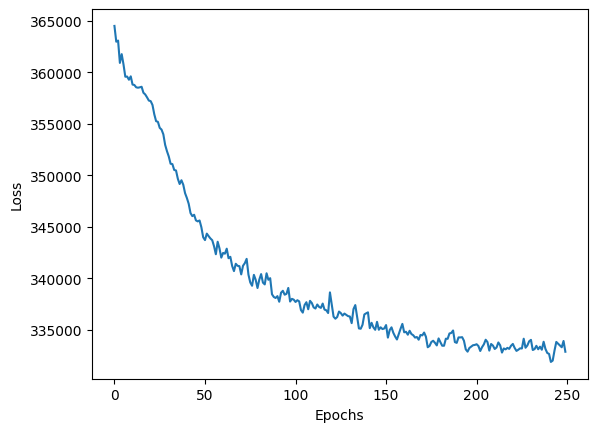

In [170]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Alternatively: Load Pre-Trained VAE
-----------------------------

In [171]:
"""
filename = 'vae_2d.pth'
# filename = 'vae_10d.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the VAE parameters can be saved:
# torch.save(vae.state_dict(), './pretrained/my_vae.pth')
"""

'\nfilename = \'vae_2d.pth\'\n# filename = \'vae_10d.pth\'\nimport urllib\nif not os.path.isdir(\'./pretrained\'):\n    os.makedirs(\'./pretrained\')\nprint(\'downloading ...\')\nurllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)\nvae.load_state_dict(torch.load(\'./pretrained/\'+filename))\nprint(\'done\')\n\n# this is how the VAE parameters can be saved:\n# torch.save(vae.state_dict(), \'./pretrained/my_vae.pth\')\n'

Evaluate on the Test Set
-------------------------

In [172]:
"""
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))
"""

"\n# set to evaluation mode\nvae.eval()\n\ntest_loss_avg, num_batches = 0, 0\nfor image_batch, _ in test_dataloader:\n\n    with torch.no_grad():\n\n        image_batch = image_batch.to(device)\n\n        # vae reconstruction\n        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)\n\n        # reconstruction error\n        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)\n\n        test_loss_avg += loss.item()\n        num_batches += 1\n\ntest_loss_avg /= num_batches\nprint('average reconstruction error: %f' % (test_loss_avg))\n"

In [173]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))


average reconstruction error: 332502.097917


Visualize Reconstructions
--------------------------

In [174]:
# @title
"""
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)
"""



"\nimport numpy as np\nimport matplotlib.pyplot as plt\nplt.ion()\n\nimport torchvision.utils\n\nvae.eval()\n\n# This function takes as an input the images to reconstruct\n# and the name of the model with which the reconstructions\n# are performed\ndef to_img(x):\n    x = x.clamp(0, 1)\n    return x\n\ndef show_image(img):\n    img = to_img(img)\n    npimg = img.numpy()\n    plt.imshow(np.transpose(npimg, (1, 2, 0)))\n\ndef visualise_output(images, model):\n\n    with torch.no_grad():\n\n        images = images.to(device)\n        images, _, _ = model(images)\n        images = images.cpu()\n        images = to_img(images)\n        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()\n        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))\n        plt.show()\n\nimages, labels = iter(test_dataloader).next()\n\n# First visualise the original images\nprint('Original images')\nshow_image(torchvision.utils.make_grid(images[1:50],10,5))\nplt.show()\n\n# Reconstruct and v

Original images


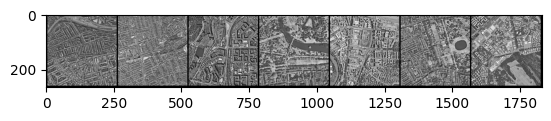

VAE reconstruction:


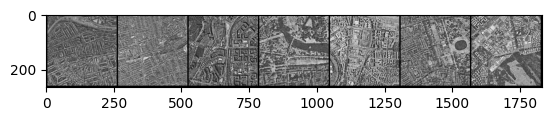

In [175]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

# Create an iterator from test_dataloader
dataiter = iter(test_dataloader)

# Get the next batch of images (and labels, if they exist)
images = next(dataiter)

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)




Interpolate in Latent Space
----------------------------

In [176]:
# @title
"""
vae.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()
"""

"\nvae.eval()\n\ndef interpolation(lambda1, model, img1, img2):\n\n    with torch.no_grad():\n\n        # latent vector of first image\n        img1 = img1.to(device)\n        latent_1, _ = model.encoder(img1)\n\n        # latent vector of second image\n        img2 = img2.to(device)\n        latent_2, _ = model.encoder(img2)\n\n        # interpolation of the two latent vectors\n        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2\n\n        # reconstruct interpolated image\n        inter_image = model.decoder(inter_latent)\n        inter_image = inter_image.cpu()\n\n        return inter_image\n\n# sort part of test set by digit\ndigits = [[] for _ in range(10)]\nfor img_batch, label_batch in test_dataloader:\n    for i in range(img_batch.size(0)):\n        digits[label_batch[i]].append(img_batch[i:i+1])\n    if sum(len(d) for d in digits) >= 1000:\n        break;\n\n# interpolation lambdas\nlambda_range=np.linspace(0,1,10)\n\nfig, axs = plt.subplots(2,5, figsize=(15, 6))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x256 and 131072x8)

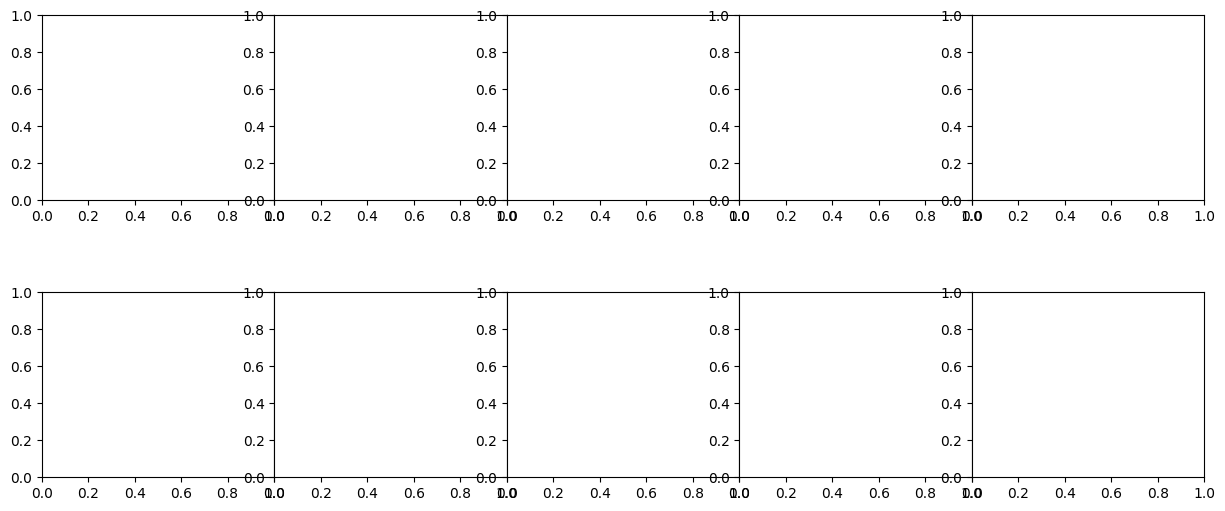

In [177]:
def interpolate_images(lambda_val, model, img1, img2):
    with torch.no_grad():
        # Encode the images to get their latent vectors
        latent_1, _ = model.encoder(img1.to(device))
        latent_2, _ = model.encoder(img2.to(device))

        # Perform the interpolation
        inter_latent = lambda_val * latent_1 + (1 - lambda_val) * latent_2

        # Decode the interpolated latent vector to get a new image
        inter_image = model.decoder(inter_latent).cpu()

    return inter_image

# Select two images for interpolation
img1 = test_dataloader.dataset[0][0].unsqueeze(0)
img2 = test_dataloader.dataset[1][0].unsqueeze(0)

# Define the range of lambda values for interpolation
lambda_range = np.linspace(0, 1, 10)

# Perform the interpolation for each lambda value and display the results
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.001)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image = interpolate_images(float(l), vae, img1, img2)
    inter_image = inter_image.view(inter_image.size(0), 256, 256)  # reshape the image if necessary
    image = inter_image.numpy()

    axs[ind].imshow(image[0, :, :], cmap='gray')
    axs[ind].set_title('lambda_val=' + str(round(l, 1)))

plt.show()


Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

In [ ]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

Show 2D Latent Space
---------------------

In [ ]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()